<a href="https://colab.research.google.com/github/KirillR911/Oleg_CV/blob/master/Untitled13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install facenet_pytorch

     |████████████████████████████████| 1.9MB 3.4MB/s 


In [0]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt

In [0]:
data_dir = "/content/drive/My Drive/oleg_cv/train_splited/"
batch_size = 32
epochs = 40

workers = 0 if os.name == 'nt' else 8
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [5]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=2
).to(device)

In [0]:
resnet = torch.load('model.pt')

In [0]:
resnet = resnet.to(device)

In [0]:

optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10, 15, 20, 25, 30, 35])

trans = transforms.Compose([
    transforms.Resize((256, 256)),
    np.float32,
    transforms.ToTensor(),
    
    fixed_image_standardization
])
dataset = datasets.ImageFolder(data_dir, transform=trans)


In [36]:
len(dataset.samples)

1407

In [0]:
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=32,
   # collate_fn=training.collate_pil,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=32,
   # collate_fn=training.collate_pil,
    sampler=SubsetRandomSampler(val_inds)
)

In [0]:

loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [39]:
from collections import Counter
print(Counter(dataset.targets))

Counter({1: 979, 0: 428})


In [0]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    if title is not None:
      ax.title.set_text(title)

    return ax

tensor([1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1])


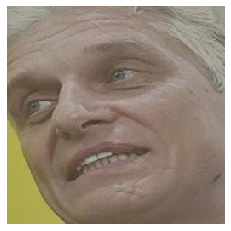

In [34]:
for x, y in (train_loader):
    imshow(x[0])
    print(y)
    break

In [41]:

writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |     9/9    | loss:    0.6909 | fps:  112.8860 | acc:    0.5807   

Epoch 1/40
----------
Train |    36/36   | loss:    0.4367 | fps:   62.0973 | acc:    0.8446   
Valid |     9/9    | loss:    0.5167 | fps:  256.2574 | acc:    0.7695   

Epoch 2/40
----------
Train |    36/36   | loss:    0.2728 | fps:   78.8152 | acc:    0.9106   
Valid |     9/9    | loss:    0.4564 | fps:  257.8356 | acc:    0.8224   

Epoch 3/40
----------
Train |    36/36   | loss:    0.3303 | fps:   78.9567 | acc:    0.8767   
Valid |     9/9    | loss:    0.3404 | fps:  260.1140 | acc:    0.8673   

Epoch 4/40
----------
Train |    36/36   | loss:    0.2188 | fps:   78.4663 | acc:    0.9245   
Valid |     9/9    | loss:    0.2953 | fps:  251.9583 | acc:    0.9054   

Epoch 5/40
----------
Train |    36/36   | loss:    0.1873 | fps:   76.9878 | acc:    0.9203   
Valid |     9/9    | loss:    0.2230 | fps:  248.7263 | acc:    0.9324   

Epoch 6/40
----------
Train |    36/36   | loss: 

In [0]:
del val_loader
del train_loader 

In [0]:
data_dir = "/content/drive/My Drive/Olegggg/dataset/"
trans = transforms.Compose([
    transforms.Resize((256, 256)),
    np.float32,
    transforms.ToTensor(),
    
    fixed_image_standardization
])
dataset2 = datasets.ImageFolder(data_dir, transform=trans)


In [0]:
img_inds = np.arange(len(dataset2))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset2,
    num_workers=workers,
    batch_size=32,
   # collate_fn=training.collate_pil,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset2,
    num_workers=workers,
    batch_size=32,
   # collate_fn=training.collate_pil,
    sampler=SubsetRandomSampler(val_inds)
)

In [45]:
from collections import Counter
print(Counter(dataset2.targets))

Counter({1: 696, 0: 379})


In [0]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    if title is not None:
      ax.title.set_text(title)

    return ax

tensor([1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 1])


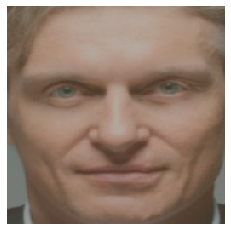

In [48]:
for x, y in (train_loader):
    imshow(x[0])
    print(y)
    break

In [49]:

writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(20):
    print('\nEpoch {}/{}'.format(epoch + 1, 20))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |     7/7    | loss:    0.1107 | fps:  173.6650 | acc:    0.9598   

Epoch 1/20
----------
Train |    27/27   | loss:    0.1927 | fps:   70.4459 | acc:    0.9378   
Valid |     7/7    | loss:    0.1307 | fps:  232.9590 | acc:    0.9590   

Epoch 2/20
----------
Train |    27/27   | loss:    0.2013 | fps:   76.2907 | acc:    0.9327   
Valid |     7/7    | loss:    0.1239 | fps:  229.2874 | acc:    0.9670   

Epoch 3/20
----------
Train |    27/27   | loss:    0.1810 | fps:   76.5979 | acc:    0.9362   
Valid |     7/7    | loss:    0.1268 | fps:  231.9945 | acc:    0.9608   

Epoch 4/20
----------
Train |    27/27   | loss:    0.2310 | fps:   76.1418 | acc:    0.9195   
Valid |     7/7    | loss:    0.1284 | fps:  227.4659 | acc:    0.9670   

Epoch 5/20
----------
Train |    27/27   | loss:    0.1842 | fps:   75.6606 | acc:    0.9349   
Valid |     7/7    | loss:    0.1271 | fps:  214.3379 | acc:    0.9670   

Epoch 6/20
----------
Train |    27/27   | loss: 

In [0]:
torch.save(resnet, 'model12.pt')

In [0]:
resnet1 = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=2
).eval().to(device)

In [0]:
del resnet1

In [0]:
resnet = torch.load('model2.pt')

RuntimeError: ignored

In [0]:
del img

NameError: ignored

In [0]:
model = resnet
img = Image.open("/content/drive/My Drive/Olegggg/dataset/1/92341231.jpg")
img.show()
img = img.resize((256,256))
trans = transforms.Compose([
    transforms.Resize((256, 256)),
    np.float32,
    transforms.ToTensor(),
    
    fixed_image_standardization
])
img = trans(img)
img1 = [ torch.zeros((3, 256, 256)) for x in range(31)]
img1.append(img)
img = torch.cat(img1)
img = img.view((32, 3, 256, 256))
model.eval()
img = img.to(device)
sg = torch.nn.Sigmoid()
print(sg(model(img)))
del img

tensor([[0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.7037, 0.2967],
        [0.2313, 0.7561]], device='cuda:0', grad_fn=<SigmoidBackward>)


In [0]:
0.7413

In [0]:
del dataset 
del resnet
del model

NameError: ignored

# Test Zone



In [0]:
data_dir = "/content/drive/My Drive/Olegggg/dataset/"
trans = transforms.Compose([
    transforms.Resize((256, 256)),
    np.float32,
    transforms.ToTensor(),
    
    fixed_image_standardization
])
dataset2 = datasets.ImageFolder(data_dir, transform=trans)


In [15]:
Counter(dataset.targets)

Counter({0: 379, 1: 696})

In [48]:

optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10, 15, 20, 25, 30, 35])
epochs = 10
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, val_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |    34/34   | loss:    0.6635 | fps:  243.8532 | acc:    0.8155   

Epoch 1/10
----------
Train |    34/34   | loss:    1.9830 | fps:   78.1650 | acc:    0.3935   
Valid |    34/34   | loss:    1.1720 | fps:  242.5185 | acc:    0.5372   

Epoch 2/10
----------
Train |    34/34   | loss:    1.0087 | fps:   77.8402 | acc:    0.4760   
Valid |    34/34   | loss:    0.7565 | fps:  232.9689 | acc:    0.5458   

Epoch 3/10
----------
Train |    34/34   | loss:    0.7155 | fps:   77.5176 | acc:    0.5005   
Valid |    34/34   | loss:    0.5795 | fps:  237.0160 | acc:    0.6647   

Epoch 4/10
----------
Train |    34/34   | loss:    0.6603 | fps:   77.6883 | acc:    0.5682   
Valid |    34/34   | loss:    0.5719 | fps:  230.6538 | acc:    0.7883   

Epoch 5/10
----------
Train |    34/34   | loss:    0.6540 | fps:   77.5380 | acc:    0.4788   
Valid |    34/34   | loss:    0.5893 | fps:  231.2430 | acc:    0.7883   

Epoch 6/10
----------
Train |    34/34   | loss: 

KeyboardInterrupt: ignored

In [0]:
import pandas as pd
idx2cl = {
    0 : 'НЕ Тиньков',
    1 : 'Тиньков',

}
def predict(image_path, model, topk=2, train_on_gpu = True):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path[1]

    # Convert to pytorch tensor
    img_tensor = image_path[0].to(device)
    toft = torch.stack([img_tensor for _ in range(32)]).to(device)


    #print(img_tensor)
    sg = torch.nn.Sigmoid()

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        #print(toft.size())
        # Model outputs log probabilities
        out = sg(model(toft))[0]
        
        #ps = torch.exp(out[0])
        #print(ps.topk(topk, dim=0))
        # Find the topk predictions
        topk, topclass = out.topk(topk, dim=0)
        #print(topclass)
        # Extract the actual classes and probabilities
        top_classes = [
            idx2cl[class_] for class_ in topclass.cpu().numpy()
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class, out

def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    #toft = torch.stack([image_path[0],image_path[0],image_path[0],image_path[0]])
    #print(torch.stack(loft).size())
    #print('Size', torch.cat(, dim = -1 ).size())
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    #result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    print('=' * 50)
    plt.figure(figsize=(16, 5))
    ax = plt.subplot()
    ax, img = imshow_tensor(img, ax=ax)
    ax.set_title(idx2cl[y_obs.item()]+' vs '+classes[0], size=20)
    #print(y_obs)

    # Set title to be the actual class
    #

    ax = plt.subplot(1, 2, 2)

    plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


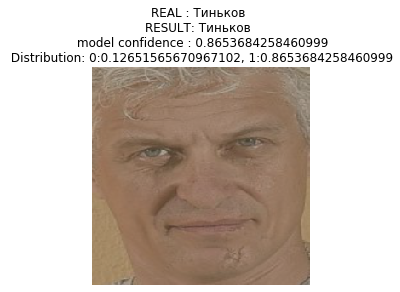

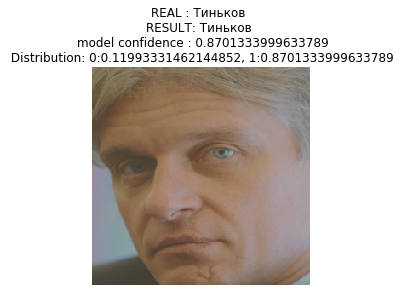

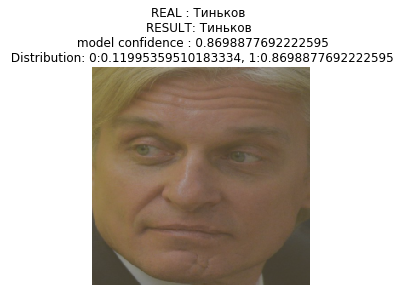

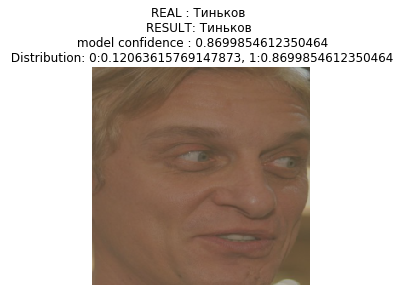

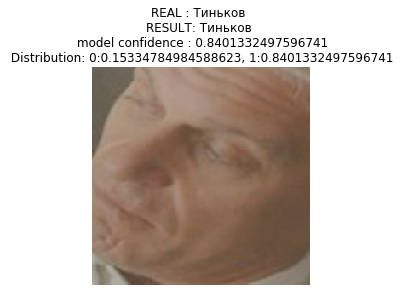

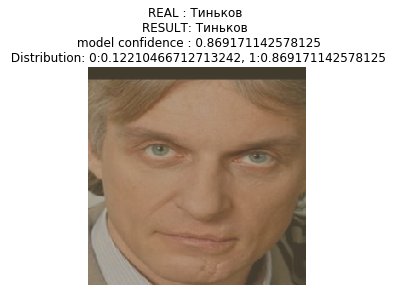

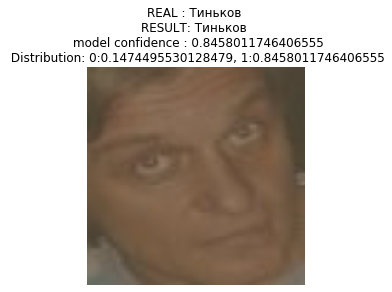

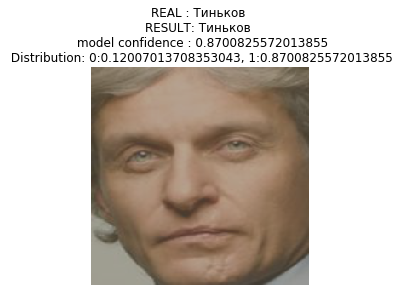

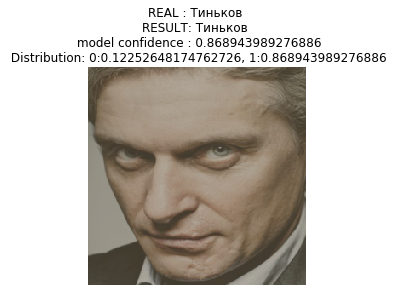

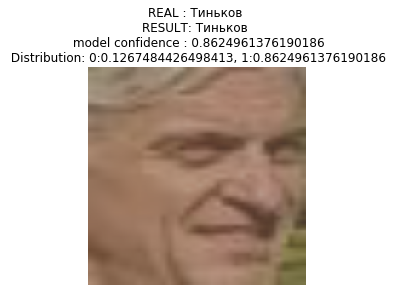

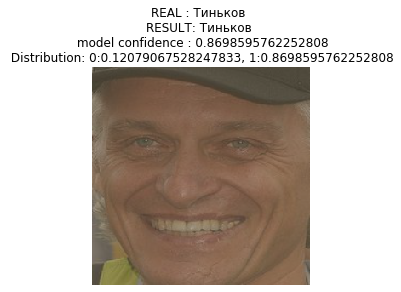

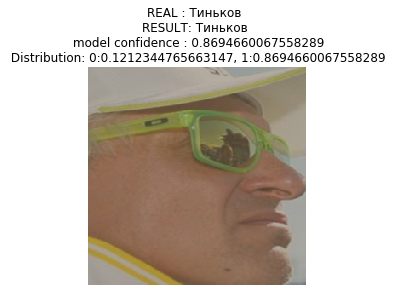

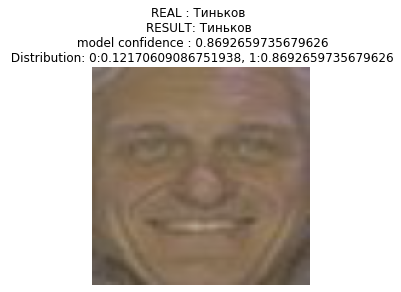

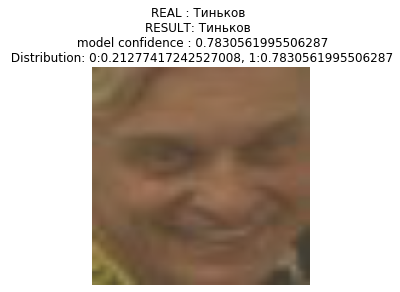

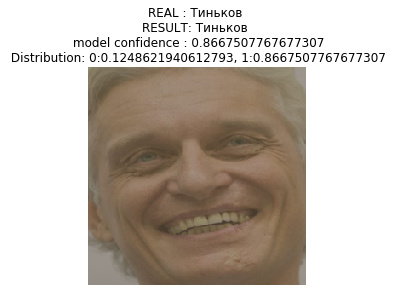

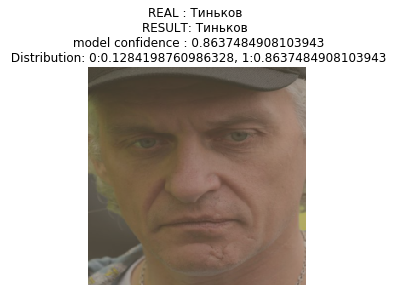

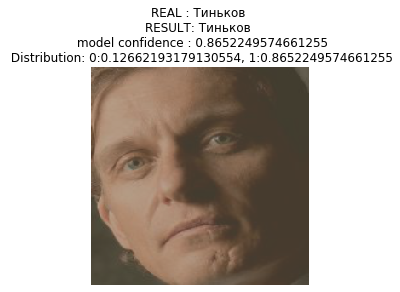

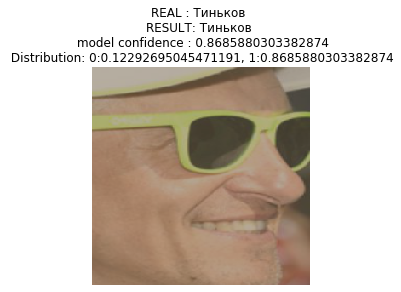

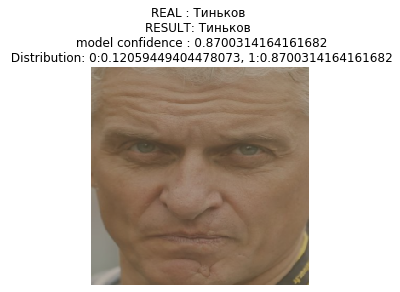

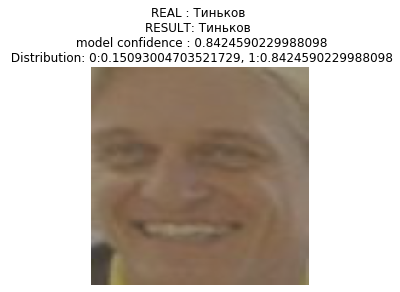

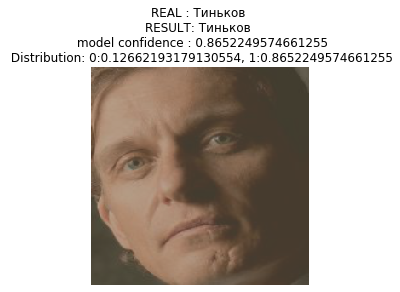

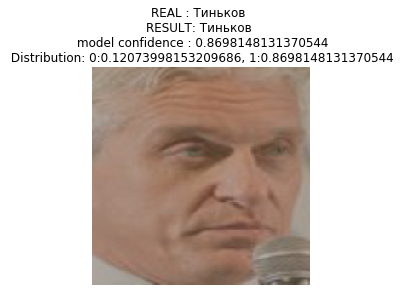

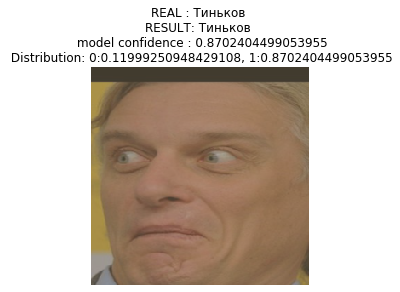

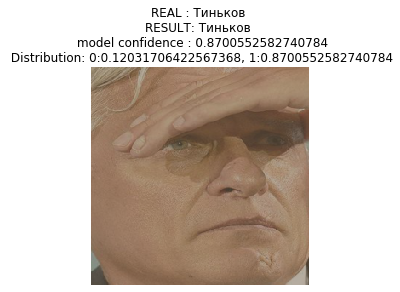

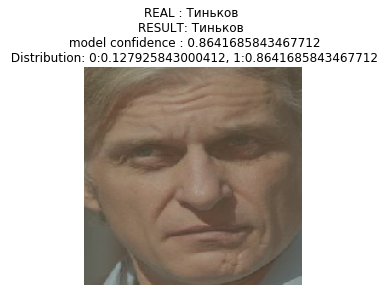

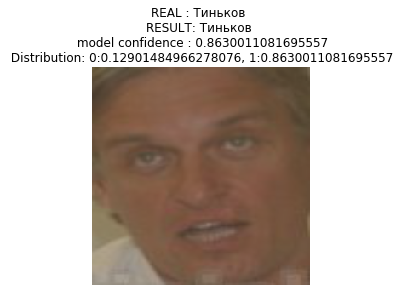

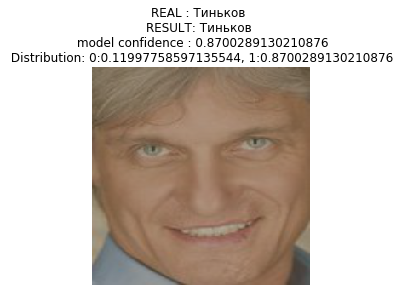

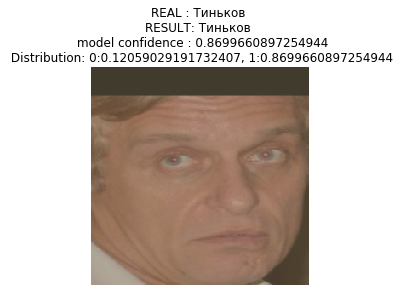

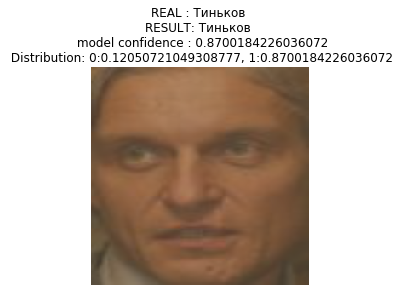

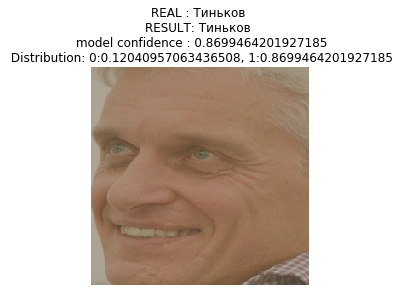

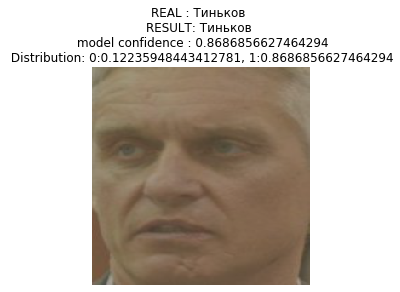

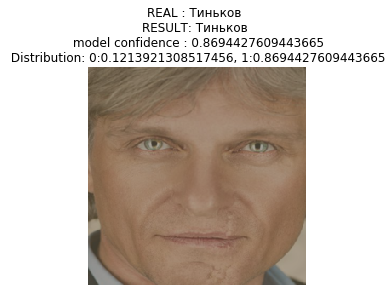

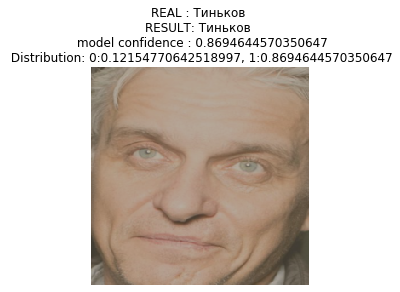

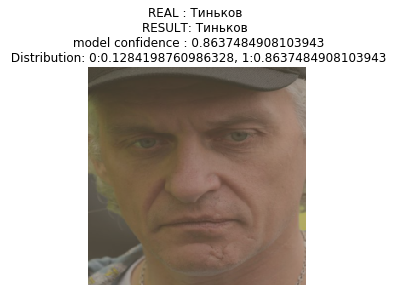

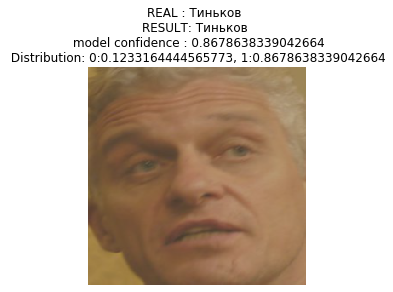

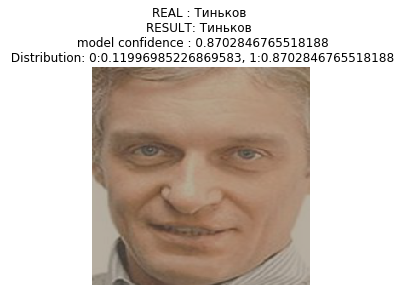

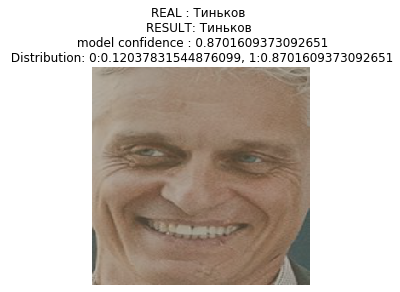

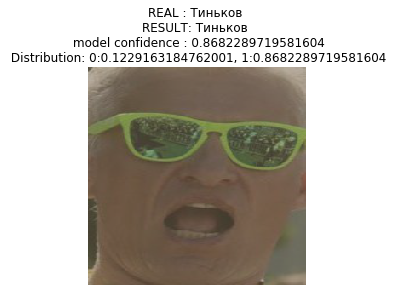

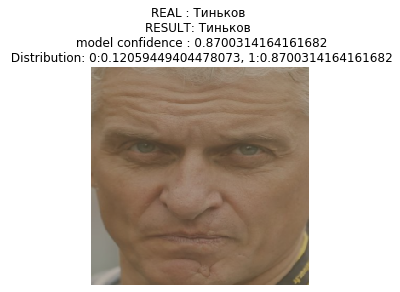

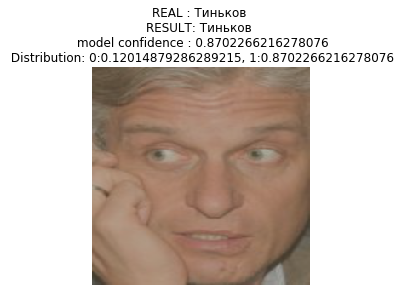

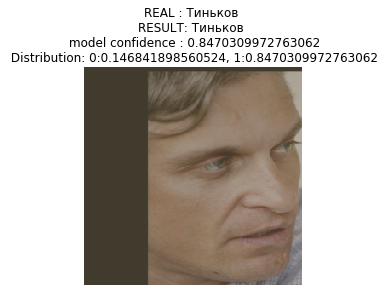

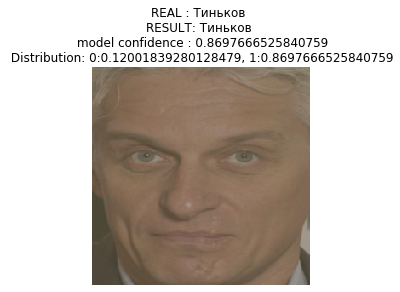

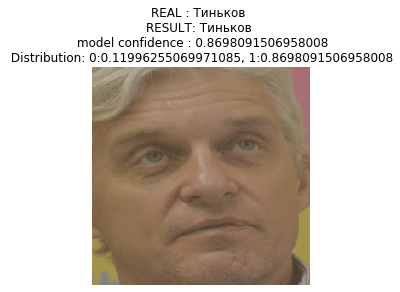

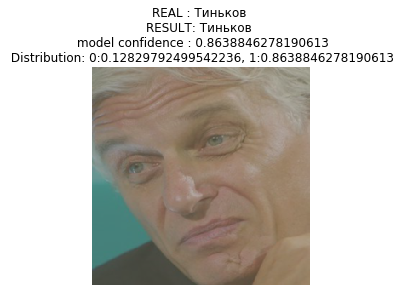

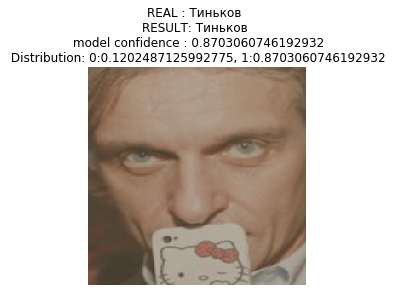

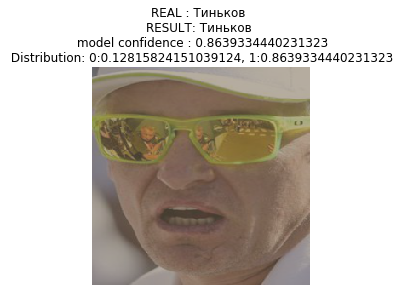

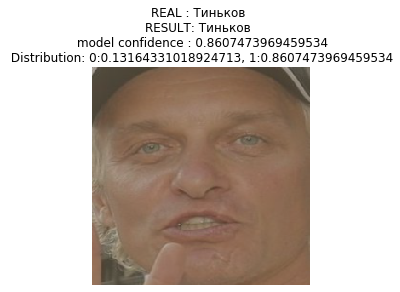

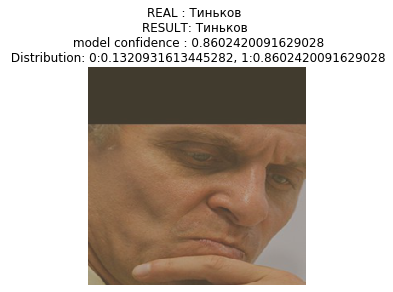

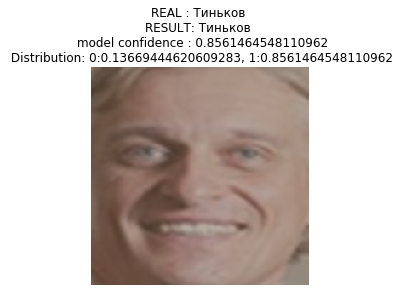

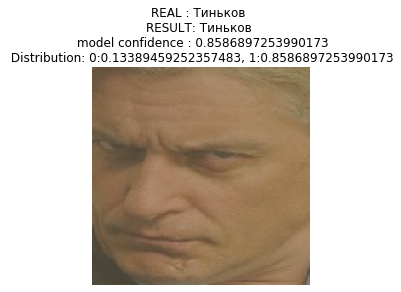

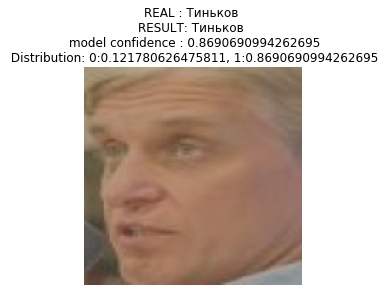

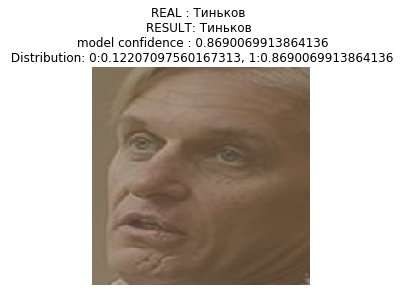

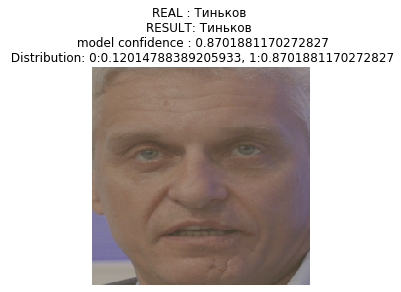

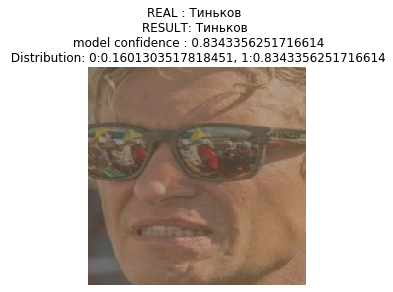

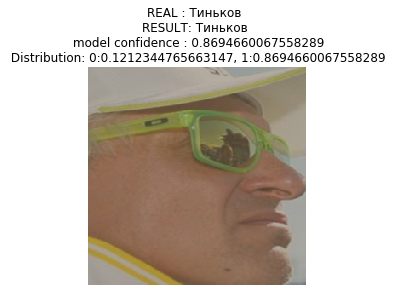

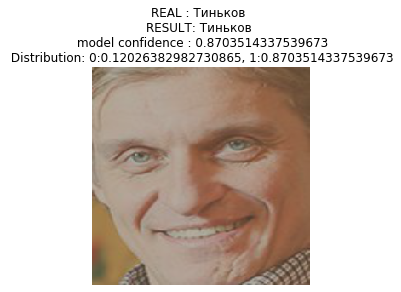

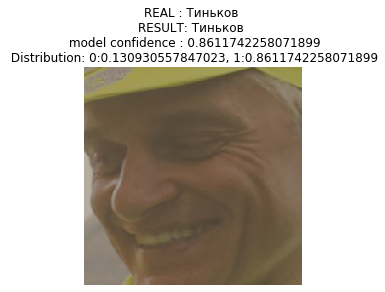

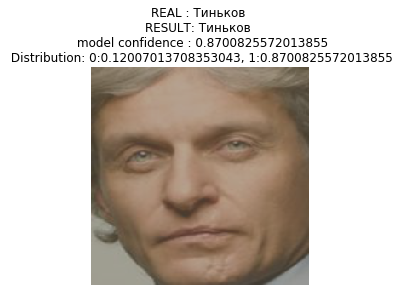

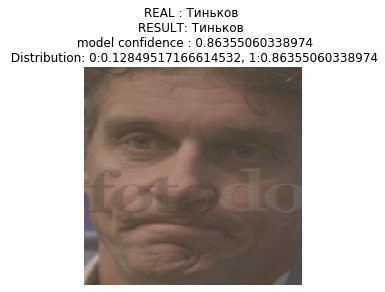

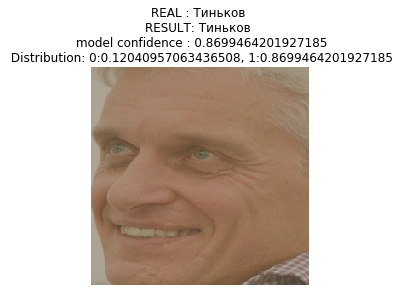

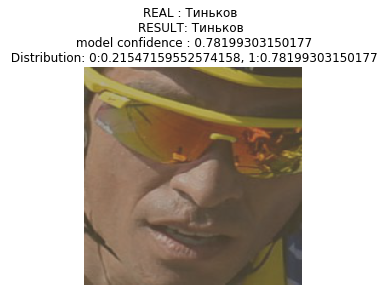

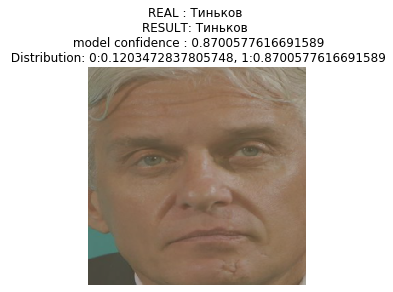

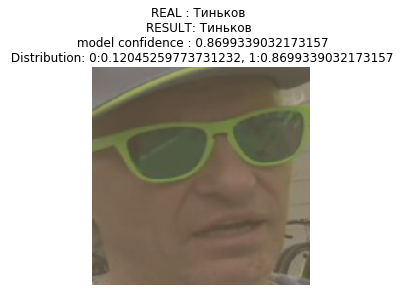

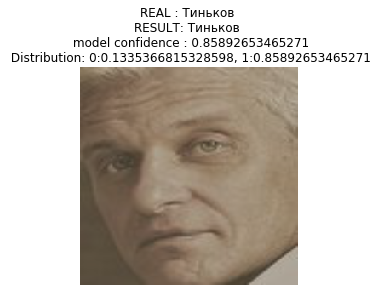

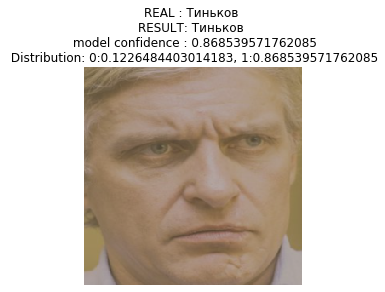

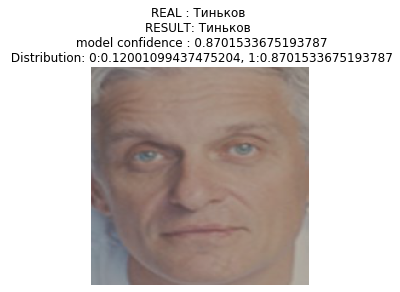

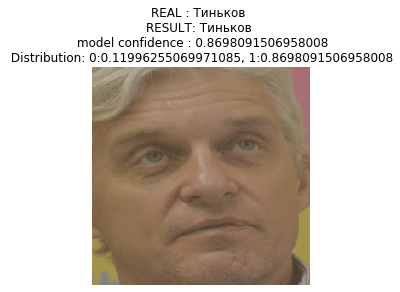

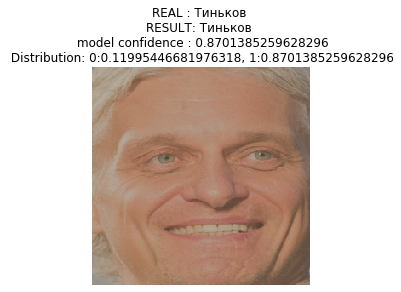

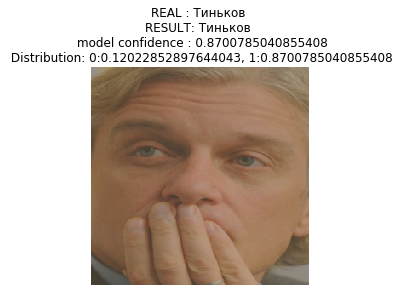

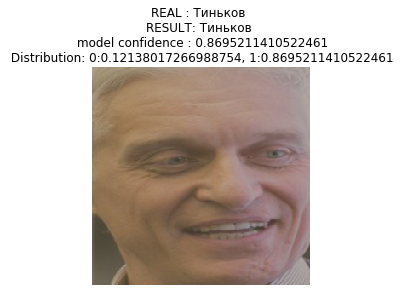

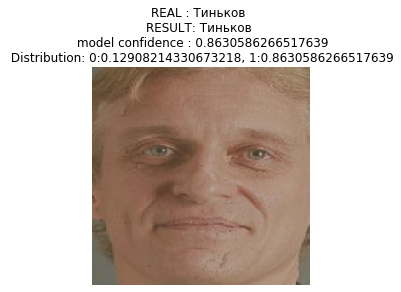

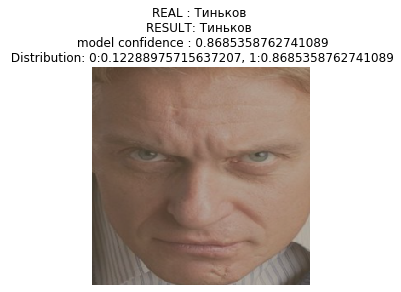

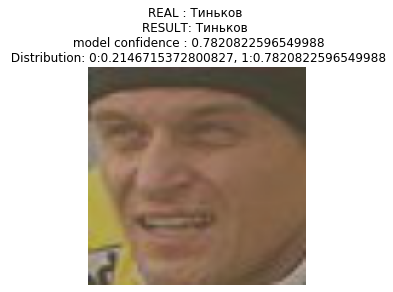

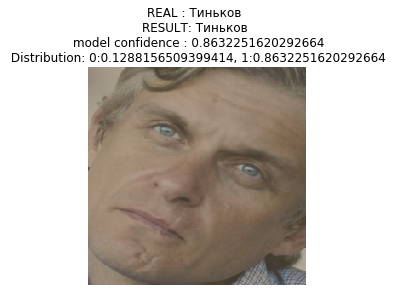

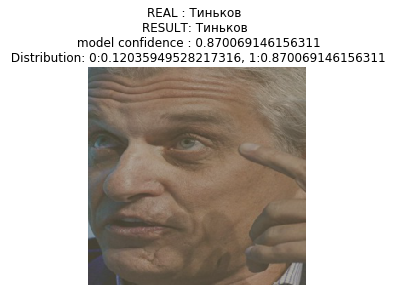

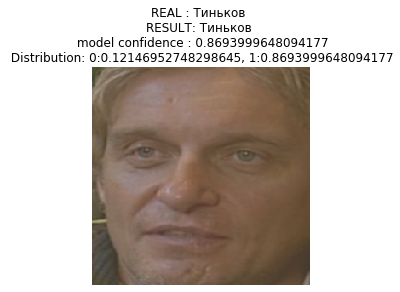

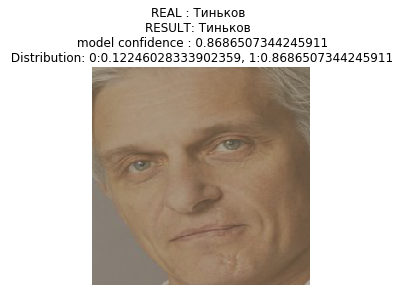

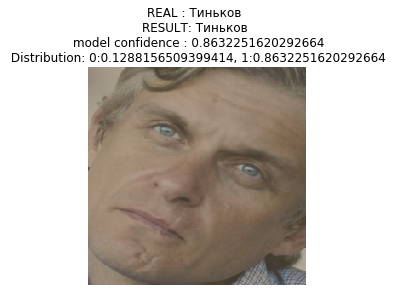

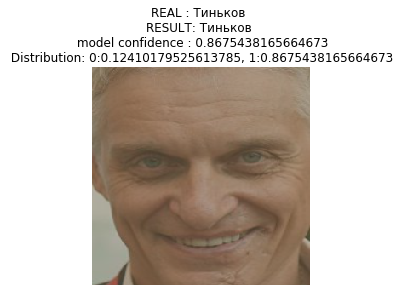

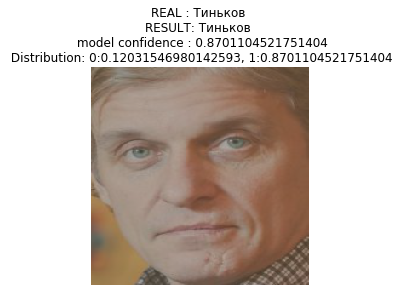

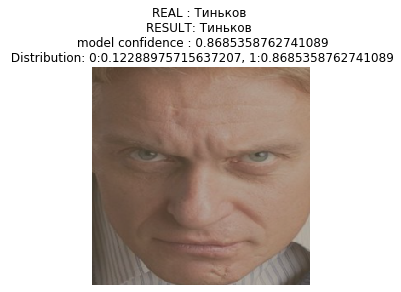

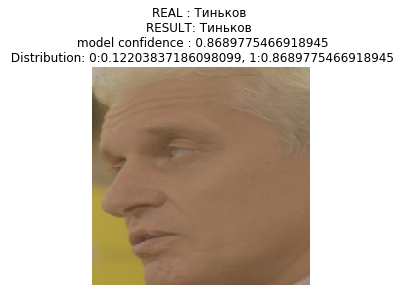

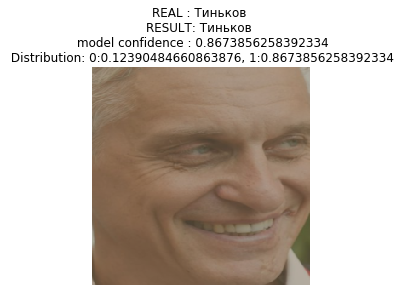

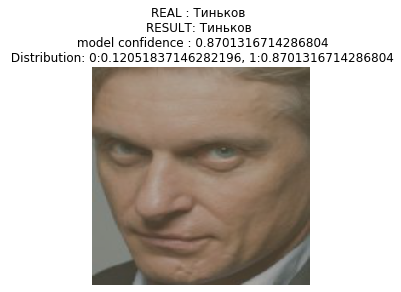

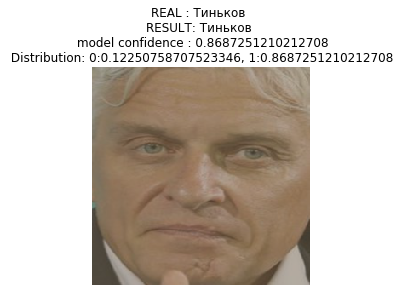

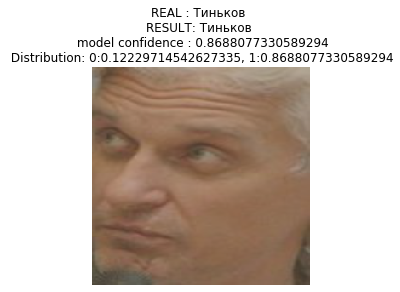

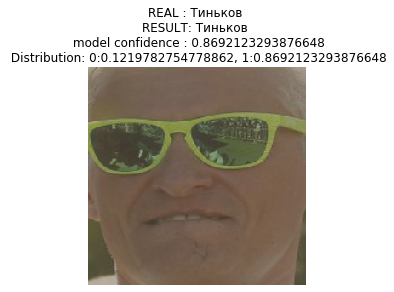

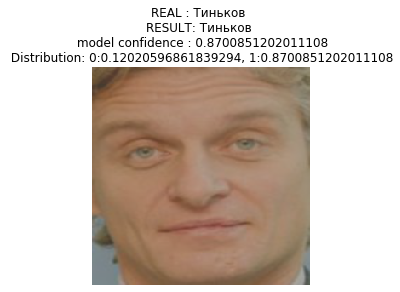

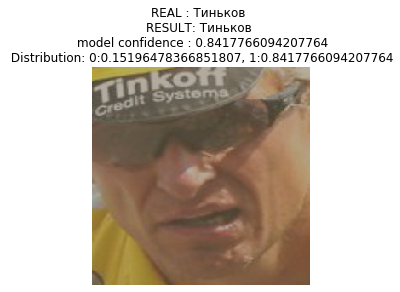

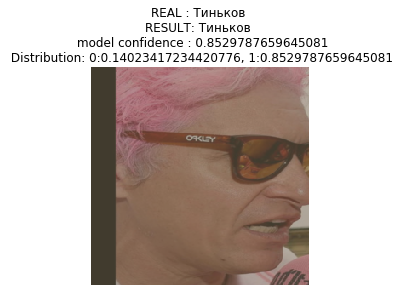

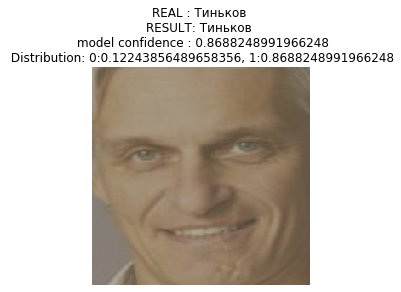

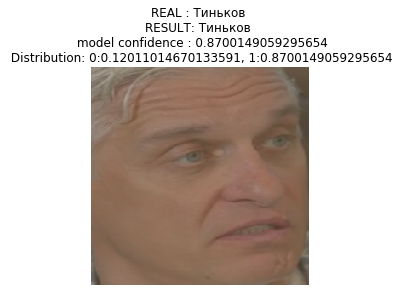

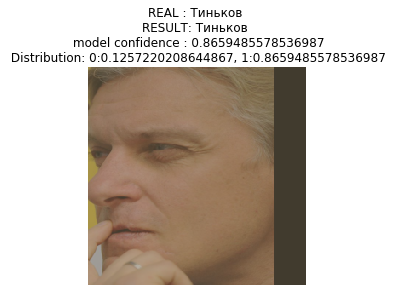

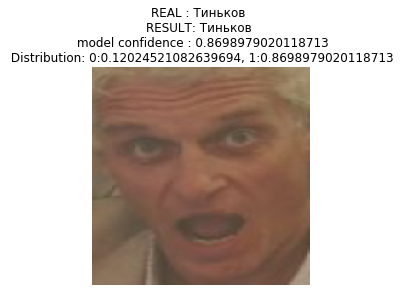

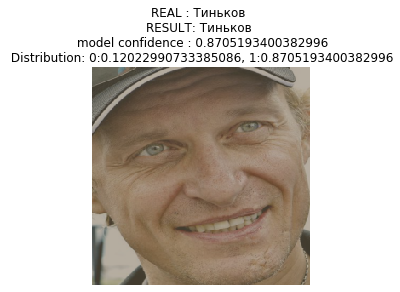

In [57]:
k = 0

for x,y in val_loader:
  for i in zip(x,y):
    img, top_p, t_c, real, out = predict(i, resnet, 2)
    if t_c[0] == idx2cl[real.item()] and t_c[0] == 'Тиньков' :
      s = "REAL : {} \nRESULT: {} \n model confidence : {}\n Distribution: 0:{}, 1:{}".format( idx2cl[real.item()], t_c[0], top_p, out[0], out[1])
      imshow(img, title = s)
  k += 1
  if k > 3:
    break
  